# 1. Data loading

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

filename = 'output.csv' # nome do dado de entrada
df = pd.read_csv(filename) # leitura do dado de entrada

In [2]:
# indata 
training_data = df[['WELL', 
                    'CALI',
                    'DEPTH_MD',
                    'GR',
                    'LITH',
                    'NPHI',
                    'RDEP',
                    'RHOB',
                    'RMED']].copy()
# indata to use 
df = df[['WELL',
         'CALI',
         'DEPTH_MD',
         'GR',
         'LITH',
         'NPHI',
         'RDEP',
         'RHOB',
         'RMED']].copy()

In [3]:
# # List the number of wells
# for well in df['WELL'].unique():
    
#     print(well)
# List of headers
plot_cols = ['WELL',
              'DEPTH_MD',
         'CALI',
         'GR',
         'LITH',
         'NPHI',
         'RDEP',
         'RHOB',
         'RMED']
df = df[plot_cols]
data_nan = df.copy()
for num, col in enumerate(data_nan.columns[2:]):
    data_nan[col] = data_nan[col].notnull() * (num + 1)
    data_nan[col].replace(0, num, inplace=True)
    print(col, num) #Print out the col name and number to verify it works
grouped = data_nan.groupby('WELL')

RMED 0
RDEP 1
RHOB 2
GR 3
NPHI 4
DTC 5
PEF 6
FORCE_2020_LITHOFACIES_LITHOLOGY 7


# 2. Plotting the Data with and without NaN

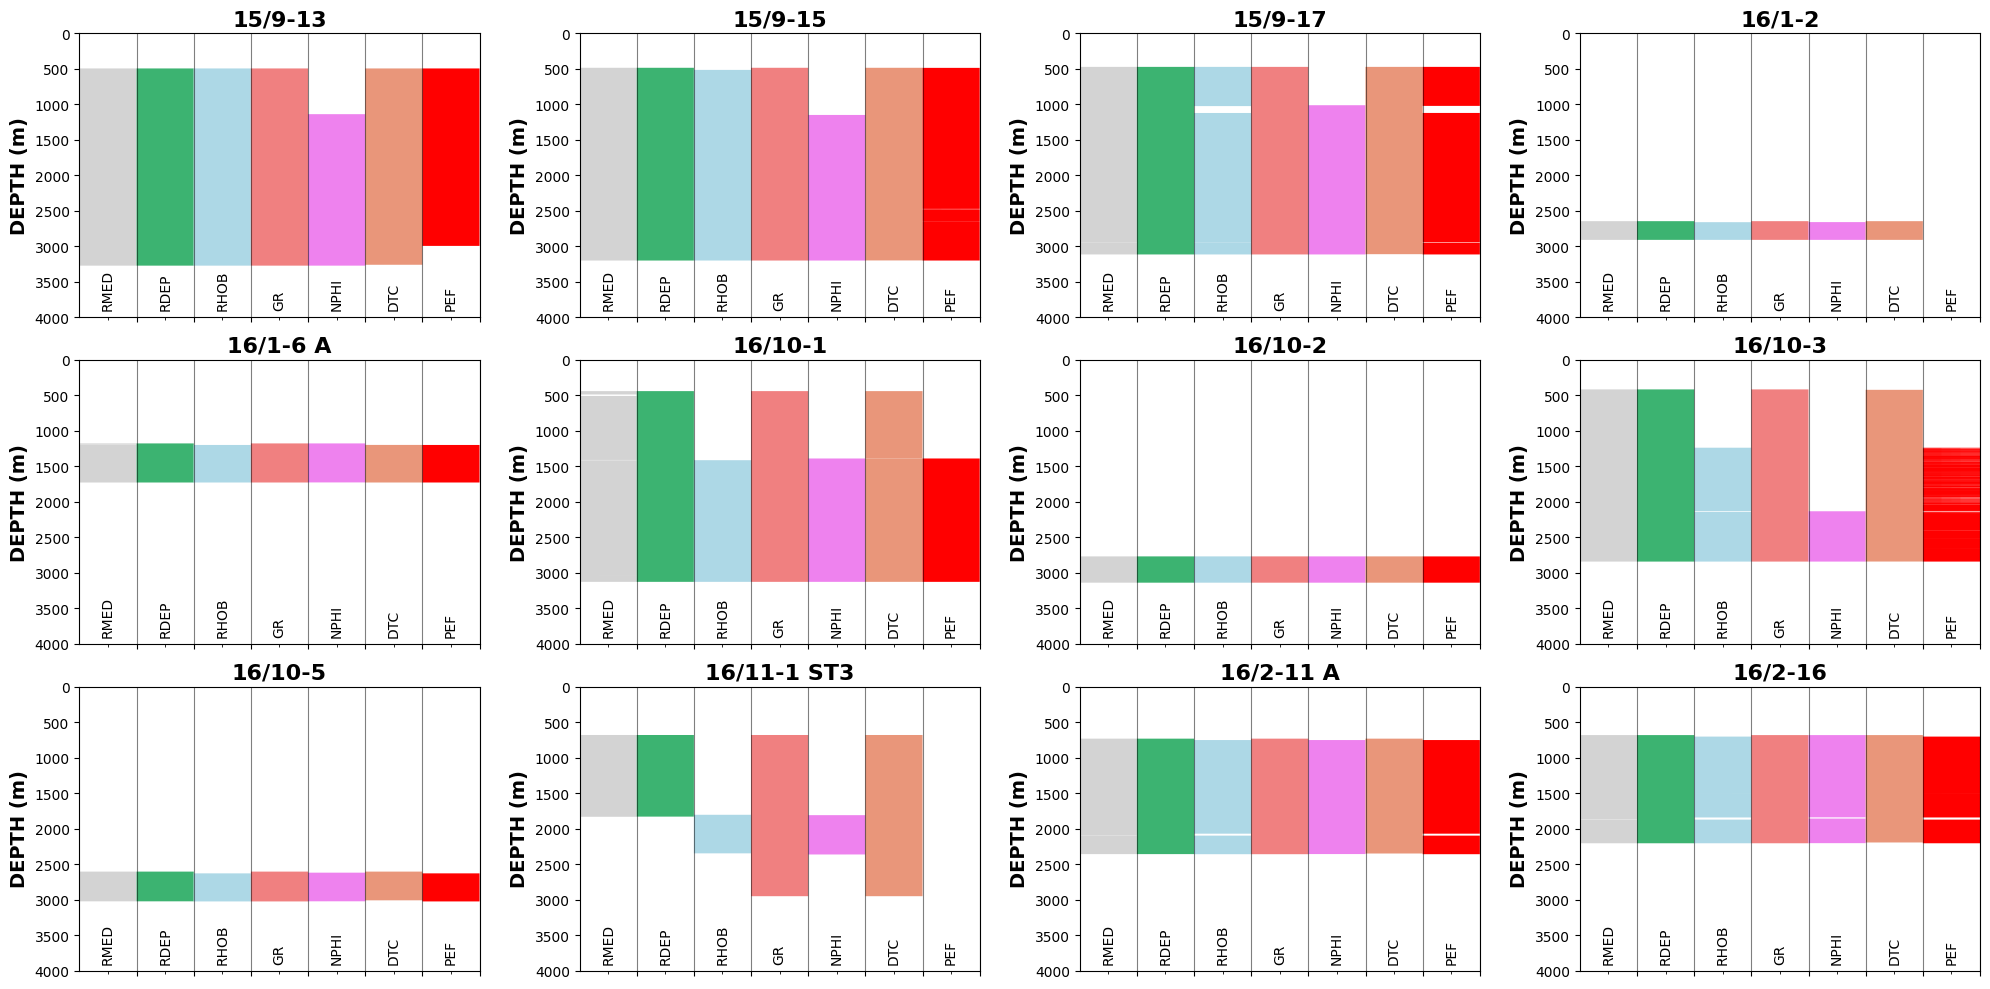

In [4]:
labels = ['CALI','GR','NPHI','RDEP','RHOB','RMED']
#Setup the figure and the subplots
fig, axs = plt.subplots(3, 4, figsize=(20,10))

#Loop through each well and column in the grouped dataframe
for (name, df), ax in zip(grouped, axs.flat):
    #ax.set_xlim(0,5) # 6 features
    ax.set_xlim(0,5) # 5 features
    
    #Setup the depth range
    ax.set_ylim(4000, 0)
    
    #Create multiple fill betweens for each curve# This is between
    # the number representing null values and the number representing
    # actual values
    
    #ax.fill_betweenx(df.DEPTH_MD, 0, df.CALI, facecolor='grey')
    ax.fill_betweenx(df.DEPTH_MD, 0, df.CALI, facecolor='lightgrey')
    ax.fill_betweenx(df.DEPTH_MD, 1, df.GR, facecolor='mediumseagreen')
    ax.fill_betweenx(df.DEPTH_MD, 2, df.NPHI, facecolor='lightblue')
    ax.fill_betweenx(df.DEPTH_MD, 3, df.RDEP, facecolor='lightcoral')
    ax.fill_betweenx(df.DEPTH_MD, 4, df.RHOB, facecolor='violet')
    ax.fill_betweenx(df.DEPTH_MD, 5, df.RMED, facecolor='darksalmon')
    # ax.fill_betweenx(df.DEPTH_MD, 6, df.PEF, facecolor='red')
    #ax.fill_betweenx(df.DEPTH_MD, 6, df.SP, facecolor='thistle')
  
    
    #Setup the grid, axis labels and ticks
    ax.grid(axis='x', alpha=0.5, color='black')
    ax.set_ylabel('DEPTH (m)', fontsize=14, fontweight='bold')
    
    #Position vertical lines at the boundaries between the bars
    ax.set_xticks([1,2,3,4,5,6], minor=False)
    
    #Position the curve names in the centre of each column
    ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5], minor=True)
    
    #Setup the x-axis tick labels
    ax.set_xticklabels(labels,  rotation='vertical', minor=True, verticalalignment='bottom')
    ax.set_xticklabels('', minor=False)
    ax.tick_params(axis='x', which='minor', pad=-6)
    
    #Assign the well name as the title to each subplot
    ax.set_title(name, fontsize=16, fontweight='bold')

plt.savefig('missingdata_northsea.pdf')
plt.tight_layout()
plt.subplots_adjust(hspace=0.15, wspace=0.25)
plt.show()

In [6]:
training_data

,WELL,CALI,DEPTH_MD,GR,LITH,NPHI,RDEP,RHOB,RMED
0,15/9-13,17.766815,1149.952026,61.443317,65000,0.592722,1.132956,1.741452,1.029300
1,15/9-13,17.820824,1150.104004,60.845684,65000,0.579078,1.138286,1.738740,1.033883
2,15/9-13,17.920202,1150.255981,60.161224,65000,0.554656,1.151047,1.734809,1.047752
3,15/9-13,18.450274,1150.407959,57.948460,30000,0.535880,1.170667,1.713422,1.054989
4,15/9-13,18.769964,1150.560059,55.263340,30000,0.533139,1.184996,1.709852,1.054584
...,...,...,...,...,...,...,...,...,...
85926,16/2-16,8.720710,2205.638428,129.111206,30000,0.131540,4.849484,2.540740,5.379713
85927,16/2-16,8.726739,2205.790283,126.967026,30000,0.131543,5.399281,2.544930,5.320911
85928,16/2-16,8.731218,2205.942383,127.495316,30000,0.132557,5.764699,2.537201,5.657949
85929,16/2-16,8.729664,2206.094482,129.244720,30000,0.128374,5.975949,2.542315,6.138004


# 3. Select the headers to use in the in-data

LITH_SI
1     15794
2      6573
3     82390
4      4968
5       188
6     11912
7      5129
8      4314
9       374
10     1498
11       58
Name: count, dtype: int64


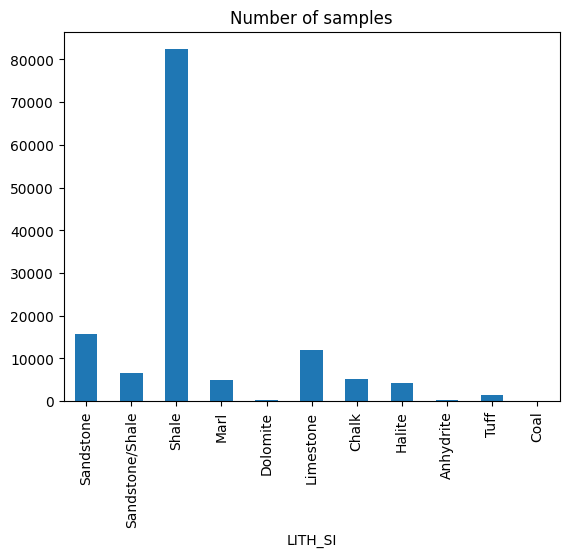

In [5]:
# training_data.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY':'FACIES'}, inplace=True)
lith_name = {30000: 'Sandstone', # sandybrown
                     65030: 'Sandstone/Shale', #darkgoldenrod
                     65000: 'Shale', # olive
                     80000: 'Marl', #gainsboro
                     74000: 'Dolomite',
                     70000: 'Limestone',
                     70032: 'Chalk',
                     88000: 'Halite',
                     86000: 'Anhydrite',
                     99000: 'Tuff',
                     90000: 'Coal',
                     93000: 'Basement'}
lith_num = {30000: 1,65030: 2,65000: 3,80000: 4,74000: 5,70000: 6,70032: 7,88000: 8,86000: 9,99000: 10,90000: 11,93000: 12}
# training_data['LITH'] = training_data['FACIES'].map(lith_name)
training_data['LITH_SI'] = training_data['LITH'].map(lith_num)
#
#plot the count of Facies
training_data['LITH_SI'].value_counts().sort_index().plot(kind='bar')
print(training_data['LITH_SI'].value_counts().sort_index())
X_ind = np.arange(0,11,1)
plt.title('Number of samples')
plt.xticks(X_ind,['Sandstone',
                  'Sandstone/Shale',
                  'Shale',
                  'Marl',
                  'Dolomite',
                  'Limestone',
                  'Chalk',
                  'Halite',
                  'Anhydrite',
                  'Tuff',
                  'Coal'])
plt.show()

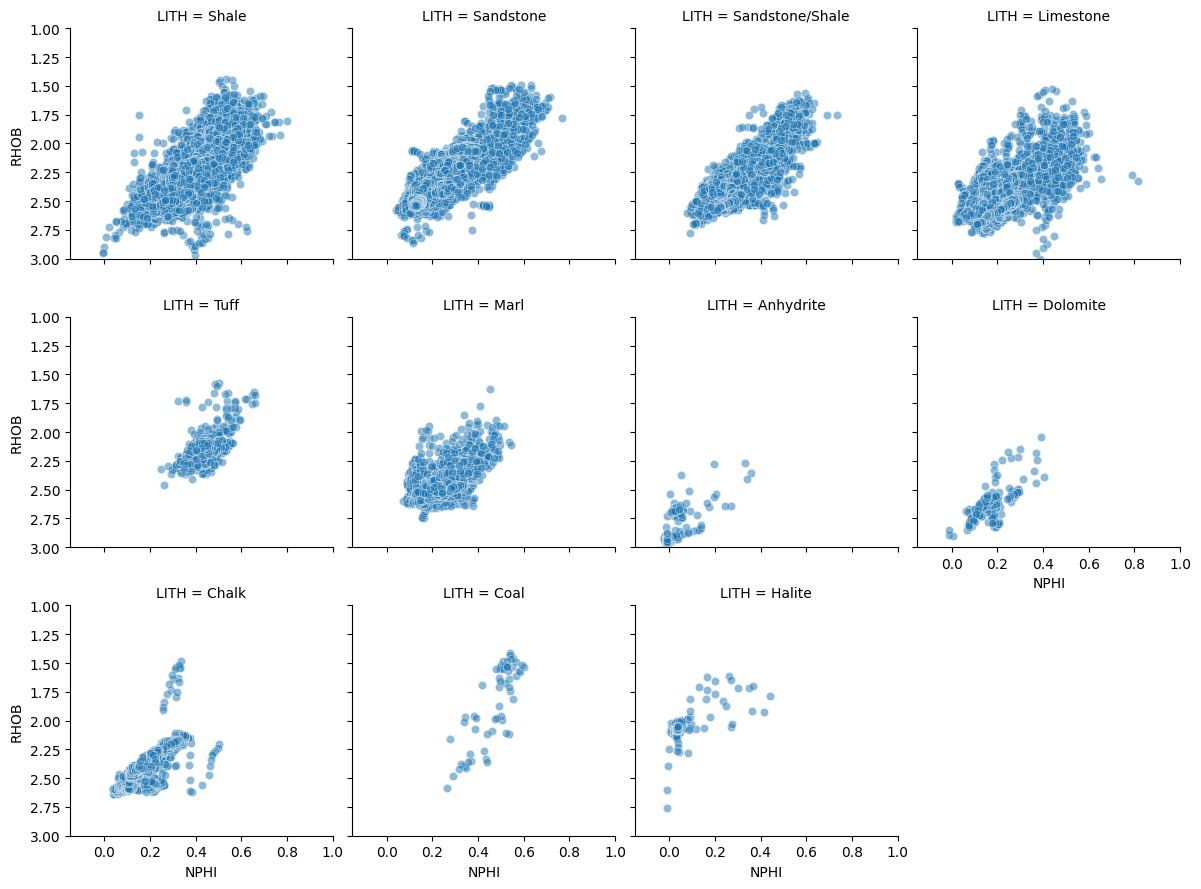

In [6]:
import seaborn as sns
g = sns.FacetGrid(training_data, col='LITH', col_wrap=4)
g.map(sns.scatterplot, 'NPHI', 'RHOB', alpha=0.5)
g.set(xlim=(-0.15, 1))
g.set(ylim=(3, 1))
plt.show()

In [7]:
# remove NaN
training_data.dropna(inplace=True)
for well in training_data['WELL'].unique():
    print(well)
blind = training_data[training_data['WELL'] == '16/2-16'] #seleciona um poço apenas do dado
training_data = training_data[training_data['WELL'] != '16/2-16'] #remove o poço do dado
training_data['WELL'].unique()

15/9-13
15/9-15
15/9-17
16/1-6 A
16/10-1
16/10-2
16/10-3
16/10-5
16/2-11 A
16/2-16


array(['15/9-13', '15/9-15', '15/9-17', '16/1-6 A', '16/10-1', '16/10-2',
       '16/10-3', '16/10-5', '16/2-11 A'], dtype=object)

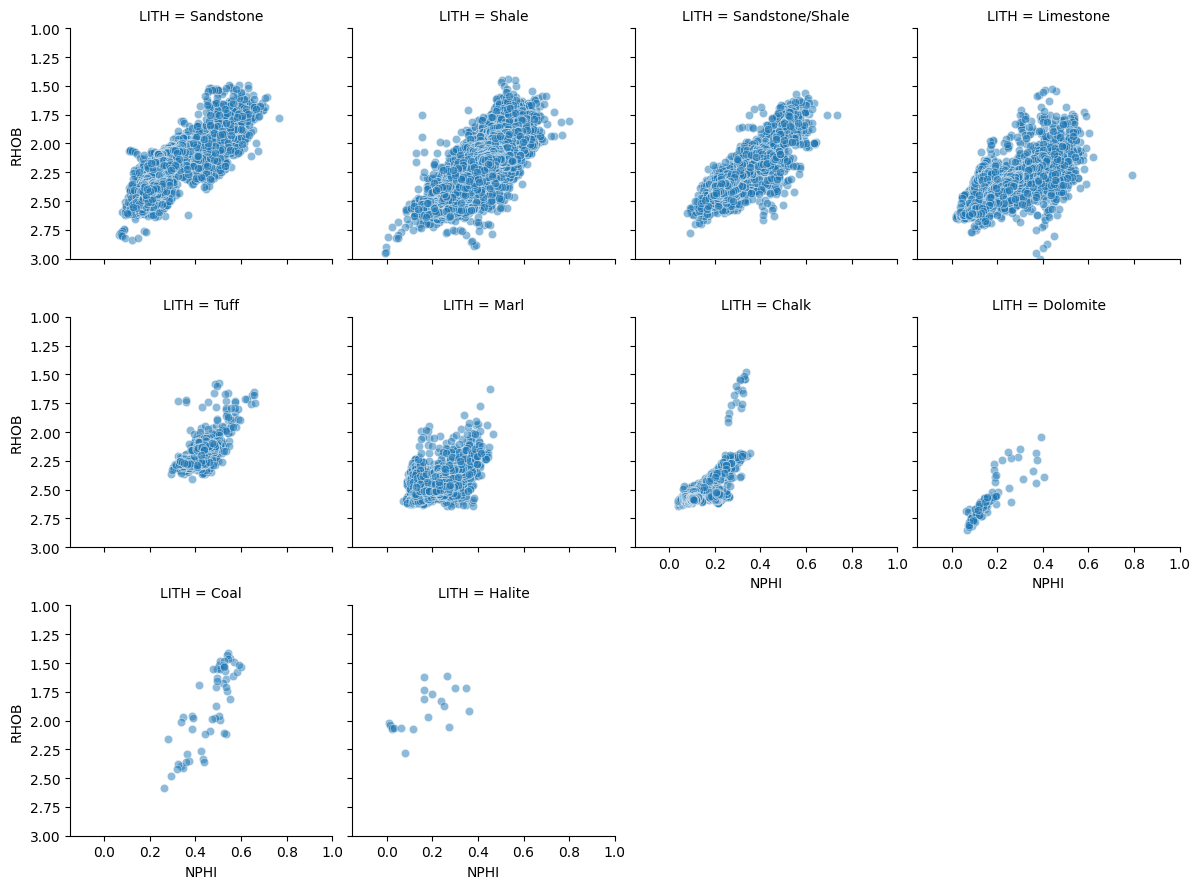

In [8]:
import seaborn as sns
#
g = sns.FacetGrid(training_data, col='LITH', col_wrap=4)
g.map(sns.scatterplot, 'NPHI', 'RHOB', alpha=0.5)
g.set(xlim=(-0.15, 1))
g.set(ylim=(3, 1))
plt.show()

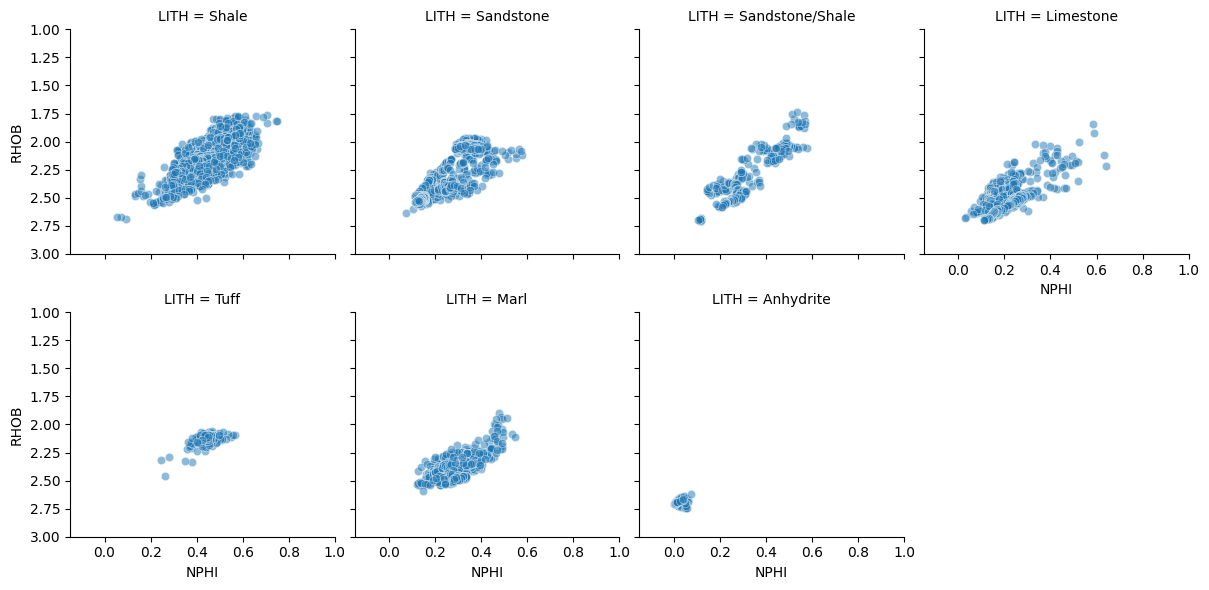

In [9]:
import seaborn as sns
#
g = sns.FacetGrid(blind, col='LITH', col_wrap=4)
g.map(sns.scatterplot, 'NPHI', 'RHOB', alpha=0.5)
g.set(xlim=(-0.15, 1))
g.set(ylim=(3, 1))
plt.show()

LITH_SI
1     1237
2      264
3     5670
4      905
6     1277
9       75
10     168
Name: count, dtype: int64


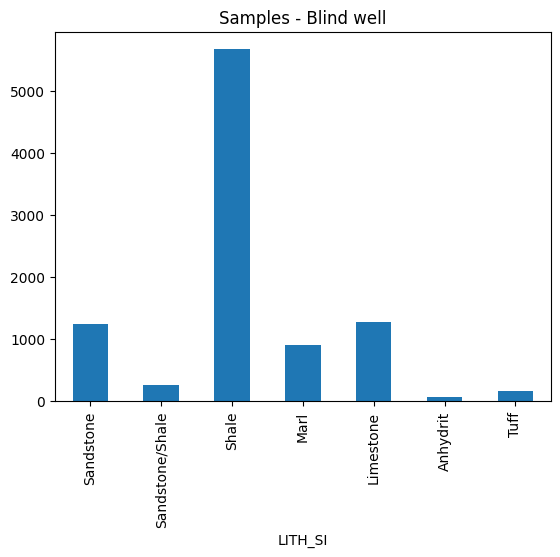

In [10]:
#plot the count of Facies
blind['LITH_SI'].value_counts().sort_index().plot(kind='bar')
print(blind['LITH_SI'].value_counts().sort_index())
X_ind = np.arange(0,7,1)
plt.title('Samples - Blind well')
plt.xticks(X_ind,['Sandstone',
                  'Sandstone/Shale',
                  'Shale',
                  'Marl',
                  'Limestone',
                  'Anhydrit',
                  'Tuff'])
plt.show()

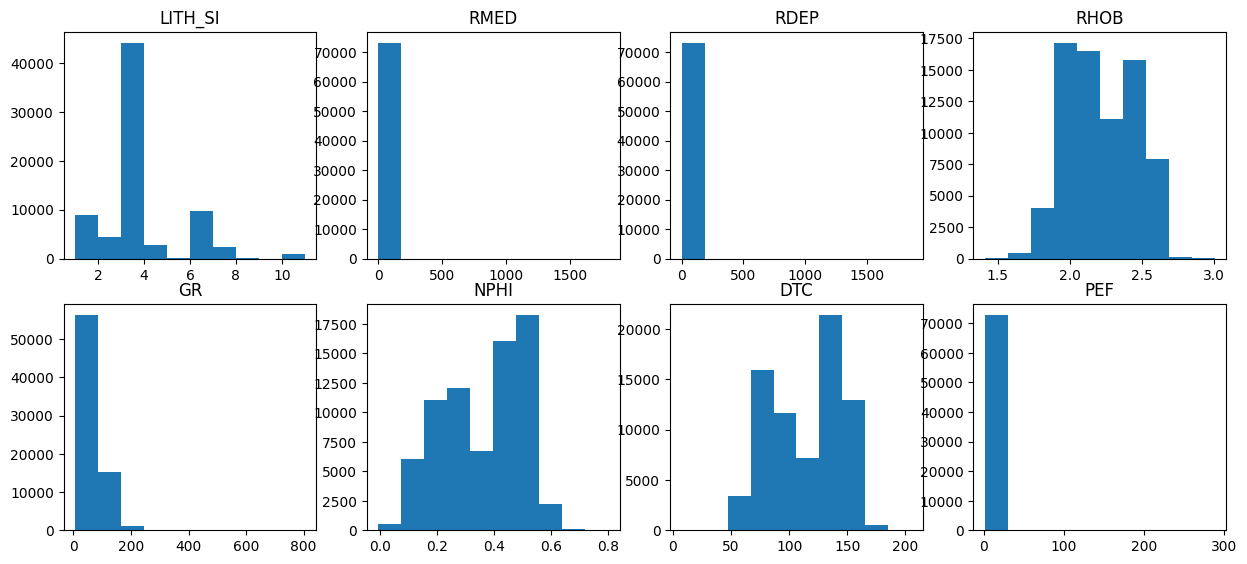

In [11]:
col_list = ['LITH_SI','CALI','GR','NPHI','RDEP','RHOB','RMED']
plt.figure(figsize=(15,10))
i=0
for col in col_list:
    i+=1
    plt.subplot(3,4,i)
    plt.hist(training_data[col])
    plt.title(col)
plt.show()

LITH_SI
1      8837
2      4314
3     44151
4      2810
5        98
6      9714
7      2259
8        20
10      866
11       56
Name: count, dtype: int64


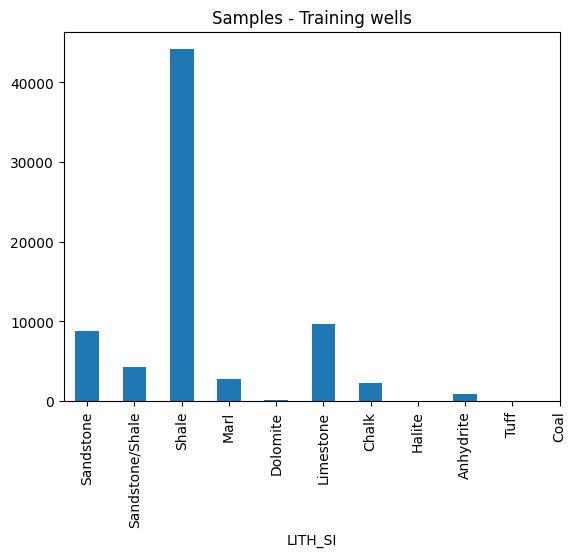

In [12]:
#plot the count of Facies
training_data['LITH_SI'].value_counts().sort_index().plot(kind='bar')
print(training_data['LITH_SI'].value_counts().sort_index())
X_ind = np.arange(0,11,1)
plt.title('Samples - Training wells')
plt.xticks(X_ind,['Sandstone',
                  'Sandstone/Shale',
                  'Shale',
                  'Marl',
                  'Dolomite',
                  'Limestone',
                  'Chalk',
                  'Halite',
                  'Anhydrite',
                  'Tuff',
                  'Coal'])
plt.show()

# 8. Prepare data for modeling and blind test well


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report

In [14]:
features = ['CALI','GR','NPHI','RDEP','RHOB','RMED']
#Select Facies
y = training_data['LITH_SI']
# well curves
X = training_data[features]
#split data to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# Blind test well
y_blind = blind['LITH_SI']
X_blind = blind[features]
X_blind_stnd = sc.transform(X_blind)
training_features = ['Ss','Ss/Sh','Sh','M','D','L','Ch','A','H','T','C']
# list_blind_full =   ['Ss','Ss/Sh','Sh','M','L','Ch','A','T','C']
list_blind_full =   ['Ss','Ss/Sh','Sh','M','NaN','L','NaN','A','T']

In [15]:
#Plot loss and accuracy
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mae']), label='Train')
    plt.plot(history.epoch, np.array(history.history['val_mae']),label = 'Val')
    plt.legend()
    plt.ylim([0,max(history.history['val_mae'])])

def plot_prediction(test_labels, test_predictions):
    plt.figure()
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [1000$]')
    plt.ylabel('Predictions [1000$]')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])

    plt.figure()
    error = test_predictions - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error [1000$]")
    _ = plt.ylabel("Count")
def plot_confusion_matrix(cm,
                          classes,
                          normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    

    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [16]:
# from sklearn.neighbors import KNeighborsClassifier # To use KNN
from sklearn.metrics import f1_score

### 9.5 CNN

In [17]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd


print(tf.__version__)

2.13.0


In [18]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


In [19]:
print(X_train.shape)
print(X_train[1].shape)
print(X_train[0])

(51187, 7)
(7,)
[-0.09681908 -0.04273459  1.18907202 -0.14358042 -0.92477089 -1.09868089
 -0.14137703]


In [20]:
sample_size = X_train.shape[0] # number of samples in train set
time_steps  = X_train.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

train_data_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
print("After reshape train data set shape:\n", train_data_reshaped.shape)
print("1 Sample shape:\n",train_data_reshaped[0].shape)
print("An example sample:\n", train_data_reshaped[0])

After reshape train data set shape:
 (51187, 7, 1)
1 Sample shape:
 (7, 1)
An example sample:
 [[-0.09681908]
 [-0.04273459]
 [ 1.18907202]
 [-0.14358042]
 [-0.92477089]
 [-1.09868089]
 [-0.14137703]]


In [21]:
test_data_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [23]:
from keras.models import Sequential
from keras.layers import Dense

def build_discriminator(input_shape):
    model = Sequential()

    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=input_shape))
    # 12 facies to be classified
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # x = LSTM(units=128, return_sequences=True, activation='relu')(discriminator_input)
    # x = LSTM(units=128, return_sequences=True, activation='relu')(x)
    # x = keras.layers.Flatten()(x)
    # x = keras.layers.Dense(512, activation='relu')(x)
    # x = keras.layers.Dropout(0.2)(x)
    # discriminator_output = keras.layers.Dense(1, activation='sigmoid')(x)

    # discriminator = Model(discriminator_input, discriminator_output, name="discriminator")
    return model

def build_generator(latent_dim):
    
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(1, activation='sigmoid'))
	# compile model
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # n_timesteps = train_data_reshaped.shape[1]
    # n_features = train_data_reshaped.shape[2]

    # generator_input = Input(shape=(n_timesteps, n_features))
    # num_lstm_units = 128

    # x = LSTM(units=num_lstm_units, return_sequences=True, activation='relu')(generator_input)
    # x = LSTM(units=num_lstm_units, return_sequences=True, activation='relu')(x)
    # x = keras.layers.Dropout(0.2)(x)
    # x = keras.layers.BatchNormalization()(x)

    # x = LSTM(units=num_lstm_units, return_sequences=True, activation='relu')(x)
    # x = LSTM(units=num_lstm_units, return_sequences=True, activation='relu')(x)
    # x = keras.layers.Dropout(0.2)(x)
    # x = keras.layers.BatchNormalization()(x)

    # x = LSTM(units=num_lstm_units, return_sequences=True, activation='relu')(x)
    # x = LSTM(units=num_lstm_units, return_sequences=True, activation='relu')(x)
    # x = keras.layers.Dropout(0.2)(x)
    # x = keras.layers.BatchNormalization()(x)

    # generator_output = Dense(n_features, activation='tanh')(x)

    # generator = Model(generator_input, generator_output, name="generator")
    return model

def build_gan(generator, discriminator):
     # make weights in the discriminator not trainable
     discriminator.trainable = False
     # connect them
     model = Sequential()
     # add generator
     model.add(generator)
     # add the discriminator
     model.add(discriminator)
     # compile model
     model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
     # discriminator.trainable = False  # Freeze the discriminator during generator training
     # gan_input = Input(shape=(n_timesteps, n_features))
     # generated_data = generator(gan_input)
     # gan_output = discriminator(generated_data)
     # gan = Model(gan_input, gan_output, name="gan")
     # optimizer_aux = tf.keras.optimizers.Adam()
     # gan.compile(loss='binary_crossentropy', optimizer=optimizer_aux)
     return model

# Assuming train_data_reshaped is your input data
n_timesteps = train_data_reshaped.shape[1]
# n_features = train_data_reshaped.shape[2]
# size of the latent space
latent_dim = 5
discriminator = build_discriminator(n_timesteps)
generator = build_generator(latent_dim)

gan = build_gan(generator, discriminator)

generator.summary()
discriminator.summary()
gan.summary()


In [ ]:
import numpy as np
# Define save_interval
save_interval = 100
def save_generated_samples(epoch, generator, examples=10, input_noise=None, output_path='generated_samples'):
    if input_noise is None:
        input_noise = np.random.normal(0, 1, (examples, n_timesteps, n_features))
optimizer_aux = tf.keras.optimizers.Adam()
# Assuming train_data_reshaped and y_train are your input data and labels
# Set up your GAN models (generator, discriminator, and gan)
generator = build_generator()
discriminator = build_discriminator(input_shape=(n_timesteps, n_features))
gan = build_gan(generator, discriminator)

# Compile the models
# optimizer_aux = Adam()

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_aux, metrics=['accuracy'])
gan.compile(loss='binary_crossentropy', optimizer=optimizer_aux)


# Define training parameters
epochs = 1000
batch_size = 512

# Training loop
for epoch in range(epochs):
    # Train discriminator on real data
    real_data = train_data_reshaped[np.random.randint(0, train_data_reshaped.shape[0], batch_size)]
    real_labels = np.ones((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_data, real_labels)

    # Train discriminator on generated data
    noise = np.random.normal(0, 1, (batch_size, n_timesteps, n_features))
    generated_data = generator.predict(noise)
    fake_labels = np.zeros((batch_size, 1))

    d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)

    # Calculate total discriminator loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, n_timesteps, n_features))
    valid_labels = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress
    print(f"Epoch {epoch + 1}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

    # Save generated samples at certain intervals (optional)
    if epoch % save_interval == 0:
        # Save generated samples
        save_generated_samples(epoch, generator)


In [ ]:
def build_conv1D_model():

    n_timesteps = train_data_reshaped.shape[1] #
    n_features  = train_data_reshaped.shape[2] # 
       
    
    model = keras.Sequential(name="model_conv1D")
    
    # 1st layer
    ks = 2
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=200, kernel_size=ks, strides=1, padding='valid', activation='relu', name="Conv1D_1"))
    model.add(keras.layers.MaxPooling1D(pool_size=1))
    model.add(keras.layers.Conv1D(filters=200, kernel_size=ks, strides=1, padding='valid', activation='relu', name="Conv1D_2"))
    model.add(keras.layers.MaxPooling1D(pool_size=1))
    model.add(keras.layers.Conv1D(filters=200, kernel_size=ks, strides=1, padding='valid', activation='relu', name="Conv1D_3"))
    model.add(keras.layers.MaxPooling1D(pool_size=1))
    model.add(keras.layers.Conv1D(filters=200, kernel_size=ks, strides=1, padding='valid', activation='relu', name="Conv1D_4"))
    model.add(keras.layers.MaxPooling1D(pool_size=1))
    
    #model.add(keras.layers.MaxPooling1D(pool_size=1, name="MaxPooling1D_fisrt"))
    
    # Dense
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(12, activation='softmax'))


    optimizer_aux = tf.keras.optimizers.Adam()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer_aux ,metrics = ['accuracy'])
    
    return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()


Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 5, 200)            600       
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 200)            0         
 D)                                                              
                                                                 
 Conv1D_2 (Conv1D)           (None, 4, 200)            80200     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 200)            0         
 g1D)                                                            
                                                                 
 Conv1D_3 (Conv1D)           (None, 3, 200)            80200     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 3, 200)           

In [25]:
earlystoping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                patience=5,
                                                verbose=1,
                                                mode='auto',
                                                restore_best_weights=True)
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      verbose=1,
                                                      save_best_only=True)

In [26]:
history_cnn = model_conv1D.fit(train_data_reshaped, y_train, validation_data = (test_data_reshaped,y_test),
                           batch_size = 512, 
                           callbacks = [model_checkpoint,earlystoping],
                           epochs = 1000,
                           verbose=1)

Epoch 1/1000
103/104 [============================>.] - ETA: 0s - loss: 0.9214 - accuracy: 0.7391
Epoch 1: val_accuracy improved from -inf to 0.80511, saving model to weights.01-0.61.h5
104/104 [==============================] - 4s 24ms/step - loss: 0.9189 - accuracy: 0.7396 - val_loss: 0.6098 - val_accuracy: 0.8051
Epoch 2/1000
103/104 [============================>.] - ETA: 0s - loss: 0.5802 - accuracy: 0.8094
Epoch 2: val_accuracy improved from 0.80511 to 0.81953, saving model to weights.02-0.55.h5
104/104 [==============================] - 2s 22ms/step - loss: 0.5799 - accuracy: 0.8097 - val_loss: 0.5480 - val_accuracy: 0.8195
Epoch 3/1000
103/104 [============================>.] - ETA: 0s - loss: 0.5312 - accuracy: 0.8217
Epoch 3: val_accuracy improved from 0.81953 to 0.83250, saving model to weights.03-0.50.h5
104/104 [==============================] - 2s 24ms/step - loss: 0.5312 - accuracy: 0.8217 - val_loss: 0.5028 - val_accuracy: 0.8325
Epoch 4/1000
103/104 [==================

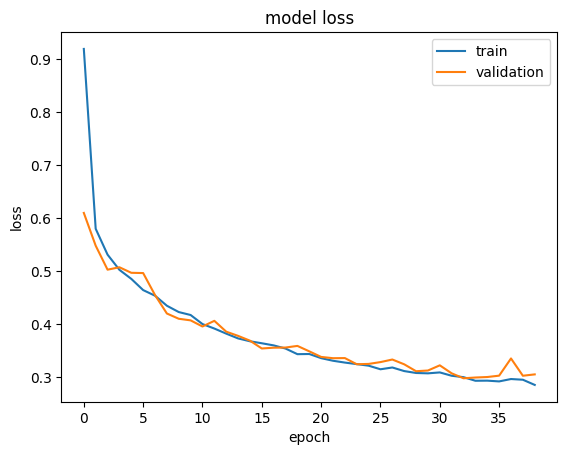

In [27]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])


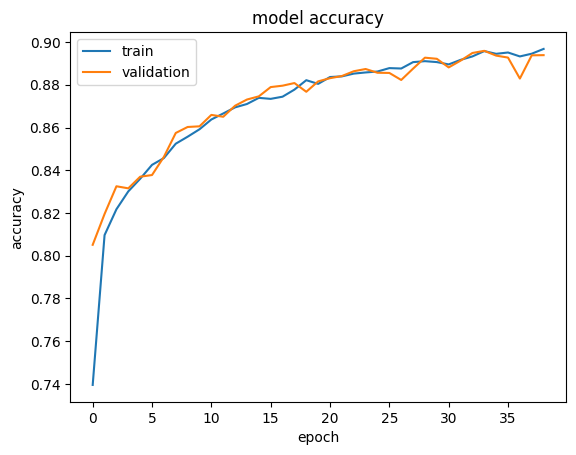

In [28]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

plt.show()

714/714 [==============================] - 1s 2ms/step
714/714 - 1s - loss: 0.2995 - accuracy: 0.8959 - 1s/epoch - 2ms/step
              precision    recall  f1-score   support

          Ss       0.87      0.84      0.85      2744
       Ss/Sh       0.73      0.53      0.61      1301
          Sh       0.93      0.98      0.95     13953
           M       0.81      0.77      0.79       914
           D       0.77      0.67      0.71        45
           L       0.89      0.83      0.86      2917
          Ch       0.76      0.81      0.78       667
           A       1.00      0.75      0.86         4
           H       1.00      0.57      0.73         7
           T       0.68      0.38      0.49       246
           C       0.67      0.60      0.63        20

    accuracy                           0.90     22818
   macro avg       0.83      0.70      0.75     22818
weighted avg       0.89      0.90      0.89     22818

Normalized confusion matrix


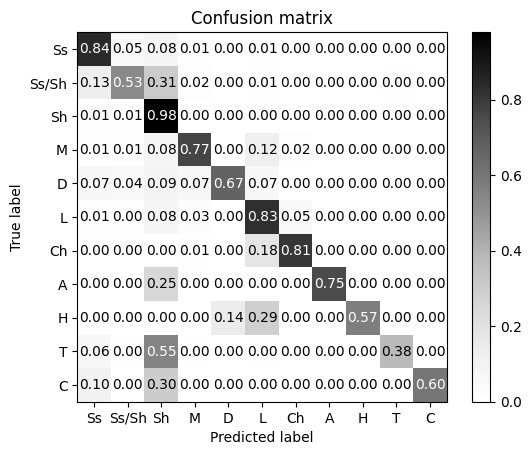

In [29]:
pred_test_cnn = model_conv1D.predict(test_data_reshaped)
pred_test_cnn = tf.argmax(pred_test_cnn, axis=1)
test_loss, test_acc = model_conv1D.evaluate(test_data_reshaped,  y_test, verbose=2)
print(classification_report(y_test, pred_test_cnn, target_names=training_features))
cm_test_cnn = confusion_matrix(y_test, pred_test_cnn)
plot_confusion_matrix(cm_test_cnn, training_features, normalize=True)

In [30]:
microF1_test_cnn = f1_score(y_test, pred_test_cnn, average='micro')
print('Test Macro f1 score:', microF1_test_cnn)
#
X_blind_reshaped = X_blind_stnd.reshape(X_blind_stnd.shape[0],X_blind_stnd.shape[1],1)
aux = model_conv1D.predict(X_blind_reshaped)
pred_blind_cnn = tf.argmax(aux, axis=1)

Test Macro f1 score: 0.8958716802524322
309/309 [==============================] - 1s 2ms/step


c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\

              precision    recall  f1-score   support

           1       0.79      0.51      0.62      1300
           2       0.15      0.19      0.17       264
           3       0.76      1.00      0.86      5670
           4       0.54      0.19      0.28      1118
           5       0.00      0.00      0.00         0
           6       0.83      0.54      0.65      1277
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00        75
          10       0.18      0.01      0.02       170

    accuracy                           0.74      9874
   macro avg       0.36      0.27      0.29      9874
weighted avg       0.72      0.74      0.70      9874

Normalized confusion matrix


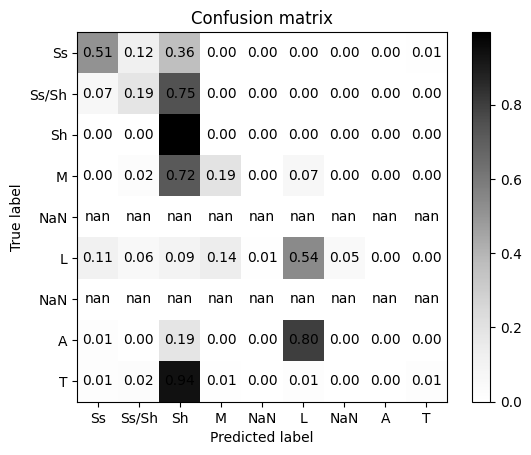

In [168]:
# Blind CM
print(classification_report(y_blind, pred_blind_cnn))
cm_cnn = confusion_matrix(y_blind, pred_blind_cnn)
list_blind_full =   ['Ss','Ss/Sh','Sh','M','NaN','L','NaN','A','T']
plot_confusion_matrix(cm_cnn, list_blind_full, normalize=True)

In [32]:
microF1_blind_cnn = f1_score(y_blind, pred_blind_cnn, average='micro')
print('Test Macro f1 score:', microF1_blind_cnn)

Test Macro f1 score: 0.7357707109580716


In [33]:
from rbflayer import RBFLayer, InitCentersRandom
def build_conv1D_rbf_model():
    #
    n_timesteps = train_data_reshaped.shape[1] #
    n_features  = train_data_reshaped.shape[2] # 
    #
    model_rbf = keras.Sequential(name="model_conv1D_rbf")
    # 1st layer
    ks = 1
    mp=1
    num_filters=128
    model_rbf.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model_rbf.add(keras.layers.Conv1D(filters=num_filters, kernel_size=ks, activation='relu', name="Conv1D_1"))
    model_rbf.add(keras.layers.Conv1D(filters=num_filters, kernel_size=ks, activation='relu', name="Conv1D_2"))
    model_rbf.add(keras.layers.MaxPooling1D(pool_size=mp))
    model_rbf.add(keras.layers.Dropout(0.2))
    model_rbf.add(keras.layers.BatchNormalization())
    # # 2nd layer
    model_rbf.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model_rbf.add(keras.layers.Conv1D(filters=num_filters, kernel_size=ks, activation='relu', name="Conv1D_3"))
    model_rbf.add(keras.layers.Conv1D(filters=num_filters, kernel_size=ks, activation='relu', name="Conv1D_4"))
    model_rbf.add(keras.layers.MaxPooling1D(pool_size=mp))
    model_rbf.add(keras.layers.Dropout(0.2))
    model_rbf.add(keras.layers.BatchNormalization())
    # # 3rd layer
    model_rbf.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model_rbf.add(keras.layers.Conv1D(filters=num_filters, kernel_size=ks, activation='relu', name="Conv1D_5"))
    model_rbf.add(keras.layers.Conv1D(filters=num_filters, kernel_size=ks, activation='relu', name="Conv1D_6"))
    model_rbf.add(keras.layers.MaxPooling1D(pool_size=mp))
    model_rbf.add(keras.layers.Dropout(0.2))
    model_rbf.add(keras.layers.BatchNormalization())
    model_rbf.add(RBFLayer(num_filters,
                           #TODO: Implement the function below
                        #    initializer=InitCentersRandom(X_blind_reshaped),
                           betas=2.0,
                           input_shape=(1,)))
    model_rbf.add(keras.layers.Flatten())
    model_rbf.add(keras.layers.Dense(512, activation='relu'))
    model_rbf.add(keras.layers.Dropout(0.2))
    model_rbf.add(keras.layers.Dense(12, activation='softmax'))


    optimizer_aux = tf.keras.optimizers.Adam()
    model_rbf.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer_aux ,metrics = ['accuracy'])
    
    return model_rbf

model_conv1D_rbf = build_conv1D_rbf_model()
model_conv1D_rbf.summary()


Model: "model_conv1D_rbf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 6, 128)            256       
                                                                 
 Conv1D_2 (Conv1D)           (None, 6, 128)            16512     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 6, 128)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 128)            0         
                                                                 
 batch_normalization (Batch  (None, 6, 128)            512       
 Normalization)                                                  
                                                                 
 input_3 (InputLayer)        multiple             

In [34]:
history_rbf = model_conv1D_rbf.fit(train_data_reshaped, y_train, validation_data = (test_data_reshaped,y_test),
                           batch_size = 512, 
                           callbacks = [model_checkpoint,earlystoping],
                           epochs = 1000,
                           verbose=1)

Epoch 1/1000
103/104 [============================>.] - ETA: 0s - loss: 1.3828 - accuracy: 0.6211
Epoch 1: val_accuracy did not improve from 0.89587
104/104 [==============================] - 6s 46ms/step - loss: 1.3781 - accuracy: 0.6221 - val_loss: 1.1661 - val_accuracy: 0.6116
Epoch 2/1000
103/104 [============================>.] - ETA: 0s - loss: 0.7615 - accuracy: 0.7612
Epoch 2: val_accuracy did not improve from 0.89587
104/104 [==============================] - 5s 44ms/step - loss: 0.7610 - accuracy: 0.7613 - val_loss: 0.8959 - val_accuracy: 0.6715
Epoch 3/1000
103/104 [============================>.] - ETA: 0s - loss: 0.6484 - accuracy: 0.7881
Epoch 3: val_accuracy did not improve from 0.89587
104/104 [==============================] - 5s 45ms/step - loss: 0.6480 - accuracy: 0.7884 - val_loss: 0.8998 - val_accuracy: 0.7092
Epoch 4/1000
103/104 [============================>.] - ETA: 0s - loss: 0.6022 - accuracy: 0.8015
Epoch 4: val_accuracy did not improve from 0.89587
104/104 

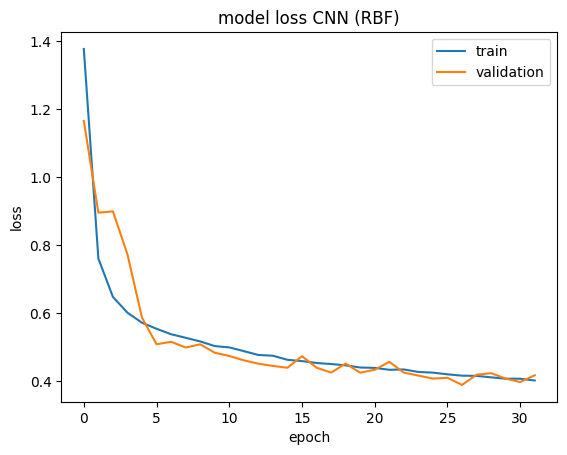

In [35]:
plt.plot(history_rbf.history['loss'])
plt.plot(history_rbf.history['val_loss'])
plt.title('model loss CNN (RBF)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

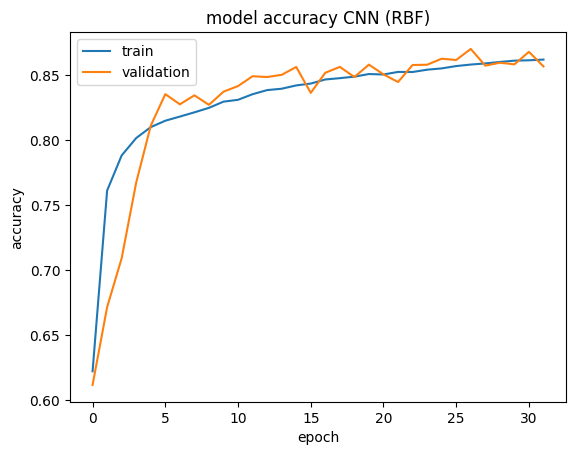

In [36]:
plt.plot(history_rbf.history['accuracy'])
plt.plot(history_rbf.history['val_accuracy'])
plt.title('model accuracy CNN (RBF)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

plt.show()

714/714 [==============================] - 1s 1ms/step


c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.82      0.81      0.82      2744
           2       0.65      0.48      0.55      1301
           3       0.92      0.97      0.94     13953
           4       0.64      0.71      0.67       914
           5       0.92      0.24      0.39        45
           6       0.85      0.78      0.81      2917
           7       0.71      0.68      0.70       667
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7
          10       0.60      0.43      0.50       246
          11       0.00      0.00      0.00        20

    accuracy                           0.87     22818
   macro avg       0.56      0.47      0.49     22818
weighted avg       0.86      0.87      0.87     22818

Normalized confusion matrix


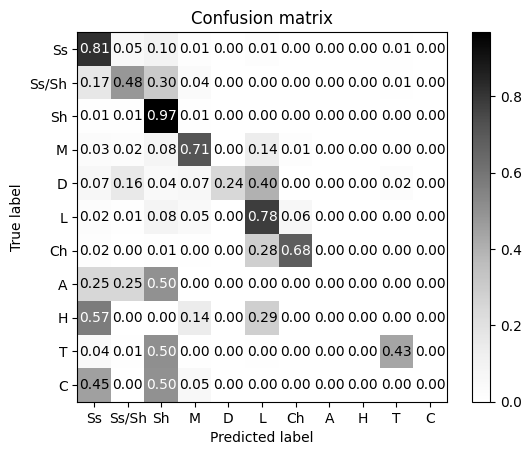

In [37]:
pred_test_rbf = model_conv1D_rbf.predict(test_data_reshaped)
pred_test_rbf = tf.argmax(pred_test_rbf, axis=1)
print(classification_report(y_test, pred_test_rbf))
cm_test_rbf = confusion_matrix(y_test, pred_test_rbf)
plot_confusion_matrix(cm_test_rbf, training_features, normalize=True)

In [38]:
microF1_test_rbf = f1_score(y_test, pred_test_rbf, average='micro')
print('Test Macro f1 score:', microF1_test_rbf)
pred_blind_rbf = model_conv1D_rbf.predict(X_blind_reshaped)
pred_blind_rbf = tf.argmax(pred_blind_rbf, axis=1)

Test Macro f1 score: 0.8704531510211236
309/309 [==============================] - 0s 1ms/step


c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\

              precision    recall  f1-score   support

           1       0.72      0.49      0.58      1300
           2       0.15      0.25      0.19       264
           3       0.77      0.98      0.86      5670
           4       0.51      0.22      0.30      1118
           6       0.85      0.51      0.63      1277
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00        75
          10       0.53      0.10      0.17       170

    accuracy                           0.73      9874
   macro avg       0.44      0.32      0.34      9874
weighted avg       0.72      0.73      0.70      9874

Normalized confusion matrix


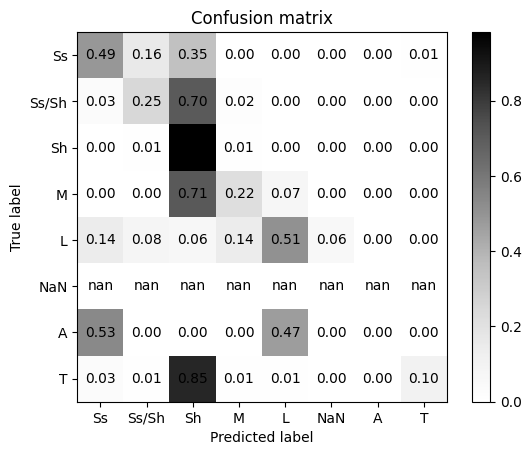

In [167]:
print(classification_report(y_blind, pred_blind_rbf))
cm_rbf = confusion_matrix(y_blind, pred_blind_rbf)
list_blind_full =   ['Ss','Ss/Sh','Sh','M','L','NaN','A','T']
plot_confusion_matrix(cm_rbf, list_blind_full, normalize=True)

In [42]:
from tensorflow.keras.layers import LSTM
#
def build_lstm_model():
    n_timesteps = train_data_reshaped.shape[1]
    n_features = train_data_reshaped.shape[2]

    model_lstm = keras.Sequential(name="model_lstm")
    
    # 1st layer
    num_lstm_units = 128
    model_lstm.add(keras.layers.Input(shape=(n_timesteps, n_features)))
    model_lstm.add(LSTM(units=num_lstm_units, return_sequences=True, activation='relu', name="LSTM_1"))
    model_lstm.add(LSTM(units=num_lstm_units, return_sequences=True, activation='relu', name="LSTM_2"))
    model_lstm.add(keras.layers.Dropout(0.2))
    model_lstm.add(keras.layers.BatchNormalization())
    
    # 2nd layer
    model_lstm.add(LSTM(units=num_lstm_units, return_sequences=True, activation='relu', name="LSTM_3"))
    model_lstm.add(LSTM(units=num_lstm_units, return_sequences=True, activation='relu', name="LSTM_4"))
    model_lstm.add(keras.layers.Dropout(0.2))
    model_lstm.add(keras.layers.BatchNormalization())
    
    # 3rd layer
    model_lstm.add(LSTM(units=num_lstm_units, return_sequences=True, activation='relu', name="LSTM_5"))
    model_lstm.add(LSTM(units=num_lstm_units, return_sequences=True, activation='relu', name="LSTM_6"))
    model_lstm.add(keras.layers.Dropout(0.2))
    model_lstm.add(keras.layers.BatchNormalization())
    
    # Dense
    model_lstm.add(keras.layers.Flatten())
    model_lstm.add(keras.layers.Dense(512, activation='relu'))
    model_lstm.add(keras.layers.Dropout(0.2))
    model_lstm.add(keras.layers.Dense(12, activation='softmax'))

    optimizer_aux = tf.keras.optimizers.Adam()
    model_lstm.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_aux, metrics=['accuracy'])

    return model_lstm

model_lstm = build_lstm_model()
model_lstm.summary()


Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 6, 128)            66560     
                                                                 
 LSTM_2 (LSTM)               (None, 6, 128)            131584    
                                                                 
 dropout_9 (Dropout)         (None, 6, 128)            0         
                                                                 
 batch_normalization_6 (Bat  (None, 6, 128)            512       
 chNormalization)                                                
                                                                 
 LSTM_3 (LSTM)               (None, 6, 128)            131584    
                                                                 
 LSTM_4 (LSTM)               (None, 6, 128)            131584    
                                                        

In [43]:
history_lstm = model_lstm.fit(train_data_reshaped, y_train, validation_data = (test_data_reshaped,y_test),
                           batch_size = 512, 
                           callbacks = [model_checkpoint,earlystoping],
                           epochs = 1000,
                           verbose=1)

Epoch 1/1000
104/104 [==============================] - ETA: 0s - loss: 0.7894 - accuracy: 0.7502
Epoch 1: val_accuracy did not improve from 0.89587
104/104 [==============================] - 24s 184ms/step - loss: 0.7894 - accuracy: 0.7502 - val_loss: 2.2560 - val_accuracy: 0.6115
Epoch 2/1000
104/104 [==============================] - ETA: 0s - loss: 0.5845 - accuracy: 0.8065
Epoch 2: val_accuracy did not improve from 0.89587
104/104 [==============================] - 19s 179ms/step - loss: 0.5845 - accuracy: 0.8065 - val_loss: 2.0856 - val_accuracy: 0.6115
Epoch 3/1000
104/104 [==============================] - ETA: 0s - loss: 0.5401 - accuracy: 0.8195
Epoch 3: val_accuracy did not improve from 0.89587
104/104 [==============================] - 19s 180ms/step - loss: 0.5401 - accuracy: 0.8195 - val_loss: 1.8736 - val_accuracy: 0.6115
Epoch 4/1000
104/104 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.8303
Epoch 4: val_accuracy did not improve from 0.89587
10

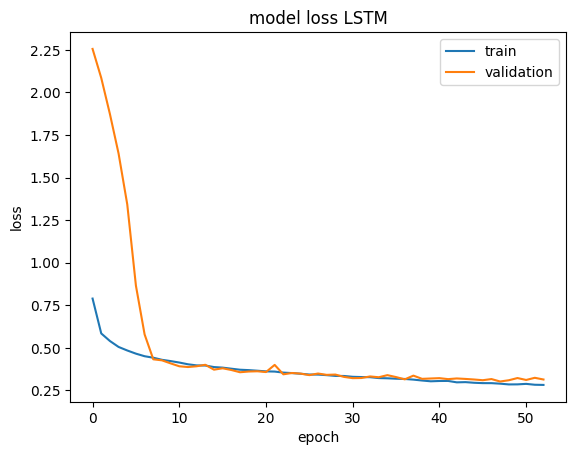

In [44]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss LSTM')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

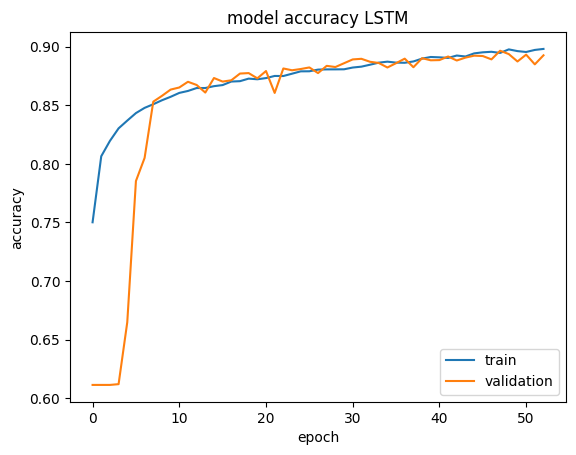

In [45]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy LSTM')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

plt.show()

714/714 [==============================] - 5s 7ms/step
              precision    recall  f1-score   support

           1       0.84      0.87      0.85      2744
           2       0.68      0.59      0.63      1301
           3       0.94      0.96      0.95     13953
           4       0.81      0.73      0.77       914
           5       0.84      0.84      0.84        45
           6       0.90      0.85      0.87      2917
           7       0.82      0.82      0.82       667
           8       1.00      0.75      0.86         4
           9       1.00      0.86      0.92         7
          10       0.54      0.51      0.53       246
          11       0.81      0.65      0.72        20

    accuracy                           0.90     22818
   macro avg       0.83      0.77      0.80     22818
weighted avg       0.89      0.90      0.89     22818

Normalized confusion matrix


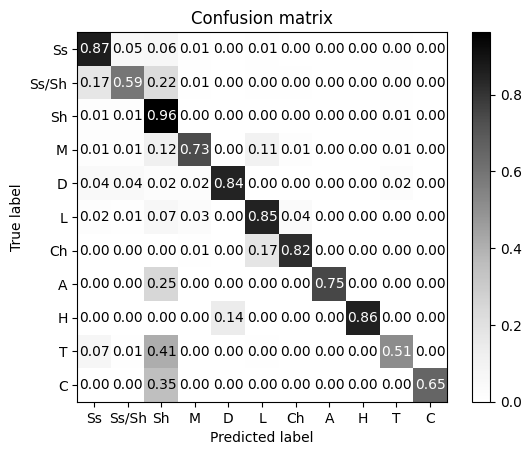

In [46]:
pred_test_lstm = model_lstm.predict(test_data_reshaped)
pred_test_lstm = tf.argmax(pred_test_lstm, axis=1)
#
print(classification_report(y_test, pred_test_lstm))
cm_test_lstm = confusion_matrix(y_test, pred_test_lstm)
plot_confusion_matrix(cm_test_lstm, training_features, normalize=True)

In [47]:
microF1_test_lstm = f1_score(y_test, pred_test_lstm, average='micro')
print('Test Macro f1 score:', microF1_test_lstm)

Test Macro f1 score: 0.8964414059076168


  1/309 [..............................] - ETA: 9s

309/309 [==============================] - 4s 12ms/step
              precision    recall  f1-score   support

           1       0.70      0.49      0.58      1300
           2       0.17      0.30      0.22       264
           3       0.79      0.99      0.88      5670
           4       0.68      0.21      0.32      1118
           5       0.00      0.00      0.00         0
           6       0.81      0.50      0.62      1277
           7       0.00      0.00      0.00         0
           9       1.00      0.19      0.31        75
          10       0.59      0.27      0.37       170
          11       0.00      0.00      0.00         0

    accuracy                           0.74      9874
   macro avg       0.47      0.29      0.33      9874
weighted avg       0.75      0.74      0.71      9874

Normalized confusion matrix


c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CometLake_05\AppData\Local\Temp\ipykernel_4088\33055311

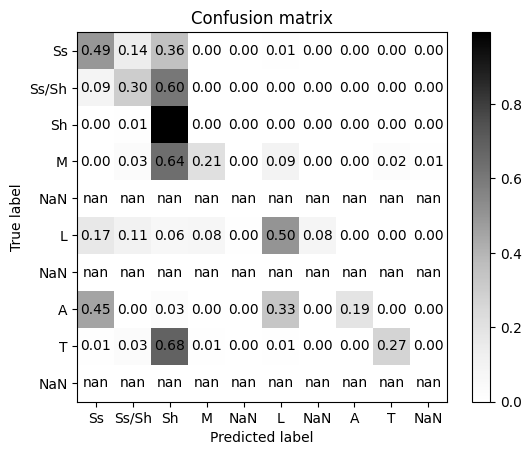

In [166]:
pred_blind_lstm = model_lstm.predict(X_blind_reshaped)
pred_blind_lstm = tf.argmax(pred_blind_lstm, axis=1)
print(classification_report(y_blind, pred_blind_lstm))
cm_lstm = confusion_matrix(y_blind, pred_blind_lstm)
list_blind_full =   ['Ss','Ss/Sh','Sh','M','NaN','L','NaN','A','T','NaN']
plot_confusion_matrix(cm_lstm, list_blind_full, normalize=True)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, MaxPooling1D, Dropout, BatchNormalization, Flatten, Dense

def build_gru_model():
    n_timesteps = train_data_reshaped.shape[1]
    n_features = train_data_reshaped.shape[2]
    
    model_gru = Sequential(name="model_gru")
    
    # GRU Layers
    num_units = 128
    model_gru.add(Input(shape=(n_timesteps, n_features)))
    model_gru.add(GRU(units=num_units, return_sequences=True, activation='relu', name="GRU_1"))
    model_gru.add(GRU(units=num_units, return_sequences=True, activation='relu', name="GRU_2"))
    model_gru.add(MaxPooling1D(pool_size=1))
    model_gru.add(Dropout(0.2))
    model_gru.add(BatchNormalization())
    
    model_gru.add(GRU(units=num_units, return_sequences=True, activation='relu', name="GRU_3"))
    model_gru.add(GRU(units=num_units, return_sequences=True, activation='relu', name="GRU_4"))
    model_gru.add(MaxPooling1D(pool_size=1))
    model_gru.add(Dropout(0.2))
    model_gru.add(BatchNormalization())
    
    model_gru.add(GRU(units=num_units, return_sequences=True, activation='relu', name="GRU_5"))
    model_gru.add(GRU(units=num_units, return_sequences=True, activation='relu', name="GRU_6"))
    model_gru.add(MaxPooling1D(pool_size=1))
    model_gru.add(Dropout(0.2))
    model_gru.add(BatchNormalization())
    
    # Flatten Layer
    model_gru.add(Flatten())
    
    # Dense Layers
    model_gru.add(Dense(512, activation='relu'))
    model_gru.add(Dropout(0.2))
    model_gru.add(Dense(12, activation='softmax'))

    # Model Compilation
    optimizer_aux = tf.keras.optimizers.Adam()
    model_gru.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_aux, metrics=['accuracy'])
    
    return model_gru

model_gru = build_gru_model()
model_gru.summary()

Model: "model_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU_1 (GRU)                 (None, 6, 128)            50304     
                                                                 
 GRU_2 (GRU)                 (None, 6, 128)            99072     
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 6, 128)            0         
 ng1D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 6, 128)            0         
                                                                 
 batch_normalization_12 (Ba  (None, 6, 128)            512       
 tchNormalization)                                               
                                                                 
 GRU_3 (GRU)                 (None, 6, 128)            99

In [52]:
history_gru = model_gru.fit(train_data_reshaped, y_train, validation_data = (test_data_reshaped,y_test),
                           batch_size = 512, 
                           callbacks = [model_checkpoint,earlystoping],
                           epochs = 1000,
                           verbose=1)

Epoch 1/1000
104/104 [==============================] - ETA: 0s - loss: 0.7217 - accuracy: 0.7703
Epoch 1: val_accuracy did not improve from 0.89644
104/104 [==============================] - 18s 124ms/step - loss: 0.7217 - accuracy: 0.7703 - val_loss: 1.8379 - val_accuracy: 0.6115
Epoch 2/1000
104/104 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.8151
Epoch 2: val_accuracy did not improve from 0.89644
104/104 [==============================] - 12s 117ms/step - loss: 0.5469 - accuracy: 0.8151 - val_loss: 1.4210 - val_accuracy: 0.6115
Epoch 3/1000
104/104 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.8306
Epoch 3: val_accuracy did not improve from 0.89644
104/104 [==============================] - 12s 115ms/step - loss: 0.5024 - accuracy: 0.8306 - val_loss: 1.3911 - val_accuracy: 0.6116
Epoch 4/1000
104/104 [==============================] - ETA: 0s - loss: 0.4744 - accuracy: 0.8403
Epoch 4: val_accuracy did not improve from 0.89644
10

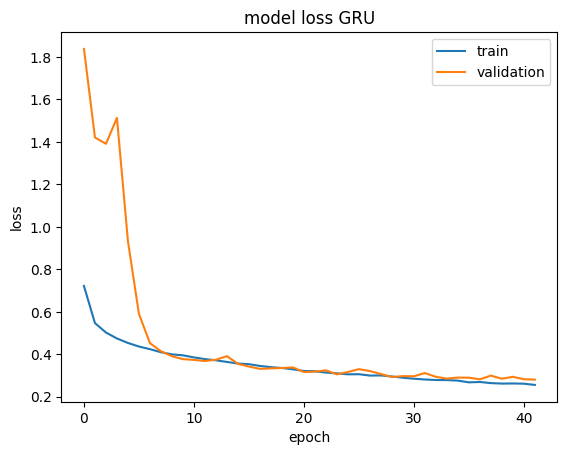

In [53]:
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('model loss GRU')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

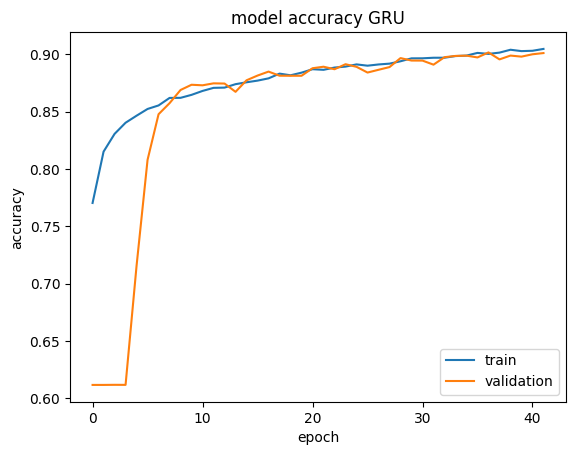

In [54]:

plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('model accuracy GRU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

714/714 [==============================] - 4s 5ms/step
              precision    recall  f1-score   support

           1       0.85      0.87      0.86      2744
           2       0.70      0.60      0.65      1301
           3       0.94      0.97      0.95     13953
           4       0.85      0.73      0.78       914
           5       0.84      0.82      0.83        45
           6       0.88      0.88      0.88      2917
           7       0.86      0.75      0.80       667
           8       1.00      0.50      0.67         4
           9       1.00      0.86      0.92         7
          10       0.61      0.61      0.61       246
          11       0.75      0.60      0.67        20

    accuracy                           0.90     22818
   macro avg       0.84      0.74      0.78     22818
weighted avg       0.90      0.90      0.90     22818

Normalized confusion matrix


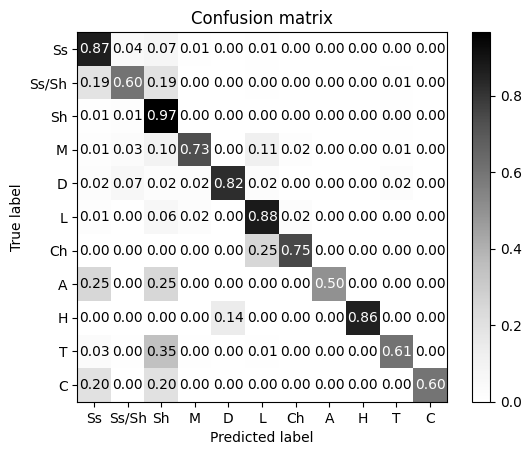

In [55]:
pred_test_gru = model_gru.predict(test_data_reshaped)
pred_test_gru = tf.argmax(pred_test_gru, axis=1)
print(classification_report(y_test, pred_test_gru))
cm_test_gru = confusion_matrix(y_test, pred_test_gru)
plot_confusion_matrix(cm_test_gru, training_features, normalize=True)

In [56]:
microF1_test_gru = f1_score(y_test, pred_test_gru, average='micro')
print('Test Macro f1 score:', microF1_test_gru)

Test Macro f1 score: 0.9017004119554738


  1/309 [..............................] - ETA: 8s

309/309 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           1       0.76      0.49      0.59      1300
           2       0.18      0.33      0.23       264
           3       0.79      0.99      0.87      5670
           4       0.61      0.23      0.33      1118
           5       0.00      0.00      0.00         0
           6       0.81      0.56      0.66      1277
           7       0.00      0.00      0.00         0
           9       1.00      0.57      0.73        75
          10       0.47      0.04      0.08       170
          11       0.00      0.00      0.00         0

    accuracy                           0.74      9874
   macro avg       0.46      0.32      0.35      9874
weighted avg       0.74      0.74      0.72      9874

Normalized confusion matrix


c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ws-python\envs\FaciesClass\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CometLake_05\AppData\Local\Temp\ipykernel_4088\33055311

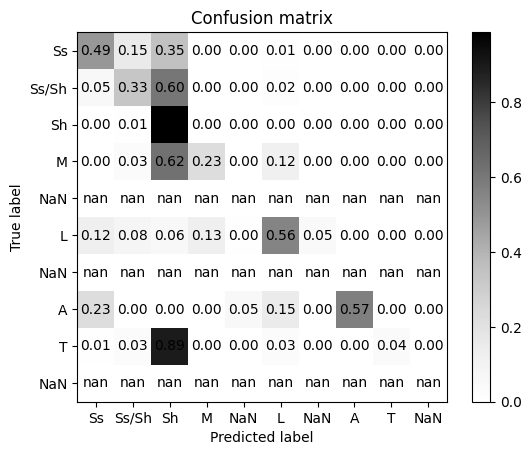

In [164]:
pred_blind_gru = model_gru.predict(X_blind_reshaped)
pred_blind_gru = tf.argmax(pred_blind_gru, axis=1)
print(classification_report(y_blind, pred_blind_gru))
cm_gru = confusion_matrix(y_blind, pred_blind_gru)
list_blind_full =   ['Ss','Ss/Sh','Sh','M','NaN','L','NaN','A','T','NaN']
plot_confusion_matrix(cm_gru, list_blind_full, normalize=True)

# 10. Model performance evaluation

I will use the diagnosis of confusion matrix from train data set to evaluate the model performance. The diagnosis of confusion matrix points how much percentage of the stone is correctly predicted.

In [58]:
### To create a data frame recording the correct prediction (normalized) of 
### facies for each machine learning algorithm

mod_test_list = ['CNN','CNN-RBF','LSTM','GRU']
cm_test_list = [cm_test_cnn, cm_test_rbf, cm_test_lstm, cm_test_gru]
face_test_list = training_features
pred_test_df = pd.DataFrame(index=training_features, columns=mod_test_list)

for mod in mod_test_list:
    
    col_index = int(mod_test_list.index(mod))
    cm = cm_test_list[col_index]
    
    for face in face_test_list:
        row_index = training_features.index(face)
        #print(face, row_index, col_index)
        pred_test_df.iloc[row_index, col_index] = cm[row_index][row_index]/sum(cm[row_index])
        

### add the accuracy factor
df_1 = pd.DataFrame([[microF1_test_cnn, 
                      microF1_test_rbf,
                      microF1_test_lstm,
                      microF1_test_gru]], index=['Accuracy'], columns=mod_test_list)    


pred_test_conc = pd.concat([pred_test_df,df_1])
pred_test_conc

,CNN,CNN-RBF,LSTM,GRU
Ss,0.839286,0.814869,0.867347,0.86516
Ss/Sh,0.529593,0.478862,0.587241,0.603382
Sh,0.978714,0.967749,0.962875,0.966459
M,0.768053,0.71116,0.734136,0.728665
D,0.666667,0.244444,0.844444,0.822222
L,0.826534,0.780254,0.847789,0.877271
Ch,0.808096,0.683658,0.818591,0.749625
A,0.75,0.0,0.75,0.5
H,0.571429,0.0,0.857143,0.857143
T,0.378049,0.434959,0.512195,0.605691


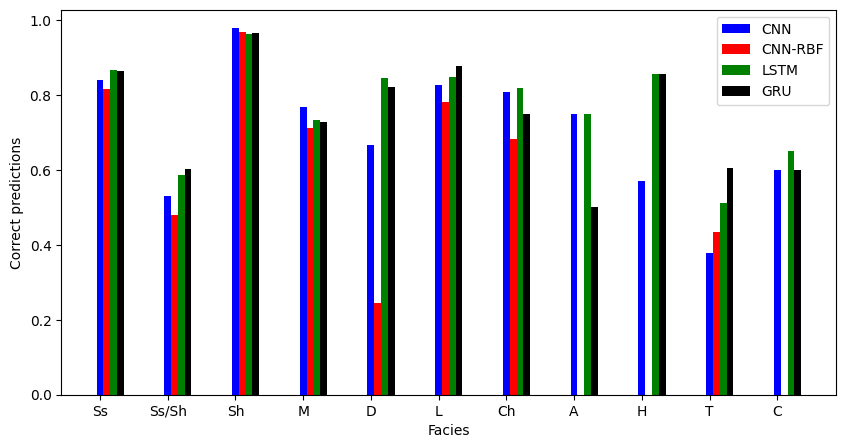

In [59]:
X_ind = np.arange(pred_test_df.shape[0])
(pred_df_index_list) = training_features
aux=0.1
plt.figure(figsize=(10,5))
plt.bar(X_ind, pred_test_df['CNN'], color='blue', width=aux)
plt.bar(X_ind+0.1, pred_test_df['CNN-RBF'], color='red', width=aux)
plt.bar(X_ind+0.2, pred_test_df['LSTM'], color='green', width=aux)
plt.bar(X_ind+0.3, pred_test_df['GRU'], color='black', width=aux)

plt.xticks(X_ind, pred_df_index_list)
plt.xlabel('Facies')
plt.ylabel('Correct predictions')
plt.legend(labels=mod_test_list)
plt.savefig('canada_performance_evaluation_test_data.pdf',bbox_inches='tight')
plt.show()

# 11. Calssifier evluation using blind test well

I will use the same method shown in item4 for evaluation.

In [65]:
### To create a data frame recording the correct prediction (normalized) of facies of blind test well for each machine learning algorithm

# blind_class  = ['Sandstone',
#                   'Sandstone/Shale',
#                   'Shale',
#                   'Marl',
#                   'Limestone',
#                   'Chalk',
#                   'Anhydrite',
#                   'Tuff']
list_blind_full =   ['Ss','Ss/Sh','Sh','M','L','A','NaN','T']
mod_list = ['CNN','CNN-RBF','LSTM','GRU']
cm_list = [cm_cnn, cm_rbf, cm_lstm, cm_gru]
pred_df = pd.DataFrame(index=list_blind_full, columns=mod_list)

for mod in mod_list:
    col_index = int(mod_list.index(mod))
    cm = cm_list[col_index]
    
    for face in list_blind_full:
        
        row_index = list_blind_full.index(face)
        #print(face, row_index, col_index)
        pred_df.iloc[row_index, col_index] = cm[row_index][row_index]/sum(cm[row_index])



C:\Users\CometLake_05\AppData\Local\Temp\ipykernel_4088\2727935510.py:24: RuntimeWarning: invalid value encountered in scalar divide
  pred_df.iloc[row_index, col_index] = cm[row_index][row_index]/sum(cm[row_index])


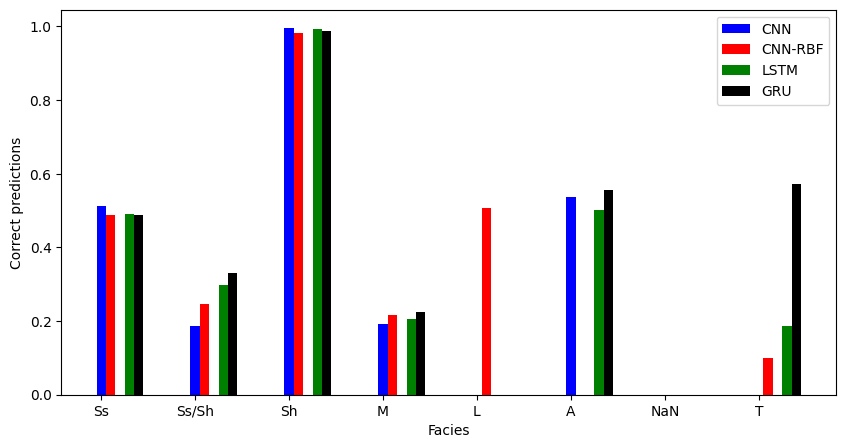

In [66]:
X_ind = np.arange(pred_df.shape[0])

aux=0.1
plt.figure(figsize=(10,5))
plt.bar(X_ind, pred_df['CNN'], color='blue', width=aux)
plt.bar(X_ind+0.1, pred_df['CNN-RBF'], color='red', width=aux)
plt.bar(X_ind+0.3, pred_df['LSTM'], color='green', width=aux)
plt.bar(X_ind+0.4, pred_df['GRU'], color='black', width=aux)
plt.xticks(X_ind, list_blind_full)
plt.xlabel('Facies')
plt.ylabel('Correct predictions')
plt.legend(labels=mod_list)
plt.savefig('canada_performance_evaluation_blind_data.pdf',bbox_inches='tight')
plt.show()

# 12. Plot the predicted facies for comparison**

In [67]:
blind = blind.copy()
blind['CNN'] = pred_blind_cnn
blind['CNN-RBF'] = pred_blind_rbf
blind['LSTM'] = pred_blind_lstm
blind['GRU'] = pred_blind_gru


blind.head()

,WELL,CALI,DEPTH_MD,GR,LITH,NPHI,RDEP,RHOB,RMED,LITH_SI,CNN,CNN-RBF,LSTM,GRU
76057,16/2-16,13.000176,705.550415,122.600769,65000,0.472988,1.364968,2.125565,1.340541,3,3,3,3,3
76058,16/2-16,12.758817,705.702393,126.172905,65000,0.476745,1.366519,2.126764,1.344673,3,3,3,3,3
76059,16/2-16,12.695938,705.854370,131.125244,65000,0.459273,1.377351,2.131069,1.355193,3,3,3,3,3
76060,16/2-16,12.646326,706.006409,129.771545,65000,0.444680,1.377473,2.140570,1.366960,3,3,3,3,3
76061,16/2-16,12.580777,706.158386,123.866241,65000,0.428803,1.404746,2.151072,1.385934,3,3,3,3,3


In [160]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

facies_colors = ['bisque',
                 'darkorange',
                 'darkgoldenrod',
                 'peachpuff',
                 'beige',
                 'white',
                 'red']

blind_class  = ['Ss',
                  'Ss/Sh',
                  'Sh',
                  'M',
                  'L',
                  'A',
                  'T']

def compare_facies_plot(logs, facie1, facie2, facie3, facie4, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='DEPTH_MD')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    num_colors = 7
    ztop=logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    #
    cluster0 = np.repeat(np.expand_dims(logs['LITH_SI'].values,1), 100, 1)
    cluster1 = np.repeat(np.expand_dims(logs[facie1].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[facie2].values,1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(logs[facie3].values,1), 100, 1)
    cluster4 = np.repeat(np.expand_dims(logs[facie4].values,1), 100, 1)
    # cluster5 = np.repeat(np.expand_dims(logs[compare5].values,1), 100, 1)
    # cluster6 = np.repeat(np.expand_dims(logs[compare6].values,1), 100, 1)
    # cluster7 = np.repeat(np.expand_dims(logs[compare7].values,1), 100, 1)
    #
    f, ax = plt.subplots(nrows=1, ncols=11, figsize=(18, 15))
    ax[0].plot(logs.CALI, logs.DEPTH_MD, '-',color='red')
    ax[1].plot(logs.GR, logs.DEPTH_MD, '-',color='blue')
    ax[2].plot(logs.NPHI, logs.DEPTH_MD, '-', color='red')
    ax[3].plot(np.log10(logs.RDEP), logs.DEPTH_MD, '-', color='green')
    ax[4].plot(logs.RHOB, logs.DEPTH_MD, '--', color='blue')
    ax[5].plot(np.log10(logs.RMED), logs.DEPTH_MD, '-', color='black')
    # ax[6].plot(logs.PEF, logs.DEPTH_MD, '-', color='black')
    im0 = ax[6].imshow(cluster0, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=num_colors)
    im1 = ax[7].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=num_colors)
    im2 = ax[8].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=num_colors)
    im3 = ax[9].imshow(cluster3, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=num_colors)
    im4 = ax[10].imshow(cluster4, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=num_colors)
    # im4 = ax[12].imshow(cluster5, interpolation='none', aspect='auto',
    #                 cmap=cmap_facies,vmin=1,vmax=num_colors)
    # im4 = ax[13].imshow(cluster6, interpolation='none', aspect='auto',
    #                 cmap=cmap_facies,vmin=1,vmax=num_colors)
    # im4 = ax[14].imshow(cluster7, interpolation='none', aspect='auto',
    #                 cmap=cmap_facies,vmin=1,vmax=num_colors)
    
            
    divider = make_axes_locatable(ax[10])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im4, cax=cax)
    cbar.set_label((30*' ').join(blind_class))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-5): # 5 represents facies number
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=5)
    
    ax[0].set_xlabel("CALI")
    ax[0].set_xlim(8,16)
    
    ax[1].set_xlabel("GR")
    ax[1].set_xlim(0,200)
    
    ax[2].set_xlabel("NPHI")
    ax[2].set_xlim(0.45,-0.15)
    
    ax[3].set_xlabel("RDEP")
    # ax[3].set_xlim(0.2,200)
    
    ax[4].set_xlabel("RHOB")
    ax[4].set_xlim(1.95,2.95)
    
    ax[5].set_xlabel("RMED")
    # ax[5].set_xlim(0.2,200)
    
    # ax[6].set_xlabel("PEF")
    # ax[6].set_xlim(logs.PEF.min(),logs.PEF.max())
    
    ax[6].set_xlabel('Facies')
    ax[7].set_xlabel(facie1)
    ax[8].set_xlabel(facie2)
    ax[9].set_xlabel(facie3)
    ax[10].set_xlabel(facie4)
    # ax[12].set_xlabel(compare5)
    # ax[13].set_xlabel(compare6)
    # ax[14].set_xlabel(compare7)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[7].set_yticklabels([]); ax[8].set_yticklabels([]); ax[9].set_yticklabels([])
    ax[10].set_yticklabels([]); #ax[11].set_yticklabels([])#; ax[12].set_yticklabels([])
    # ax[13].set_yticklabels([]); ax[14].set_yticklabels([])
    
    
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    ax[7].set_xticklabels([])
    ax[8].set_xticklabels([])
    ax[9].set_xticklabels([])
    ax[10].set_xticklabels([])
    #ax[11].set_xticklabels([])
    # ax[12].set_xticklabels([])
    # ax[13].set_xticklabels([])
    # ax[14].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['WELL'], fontsize=14,y=0.94)

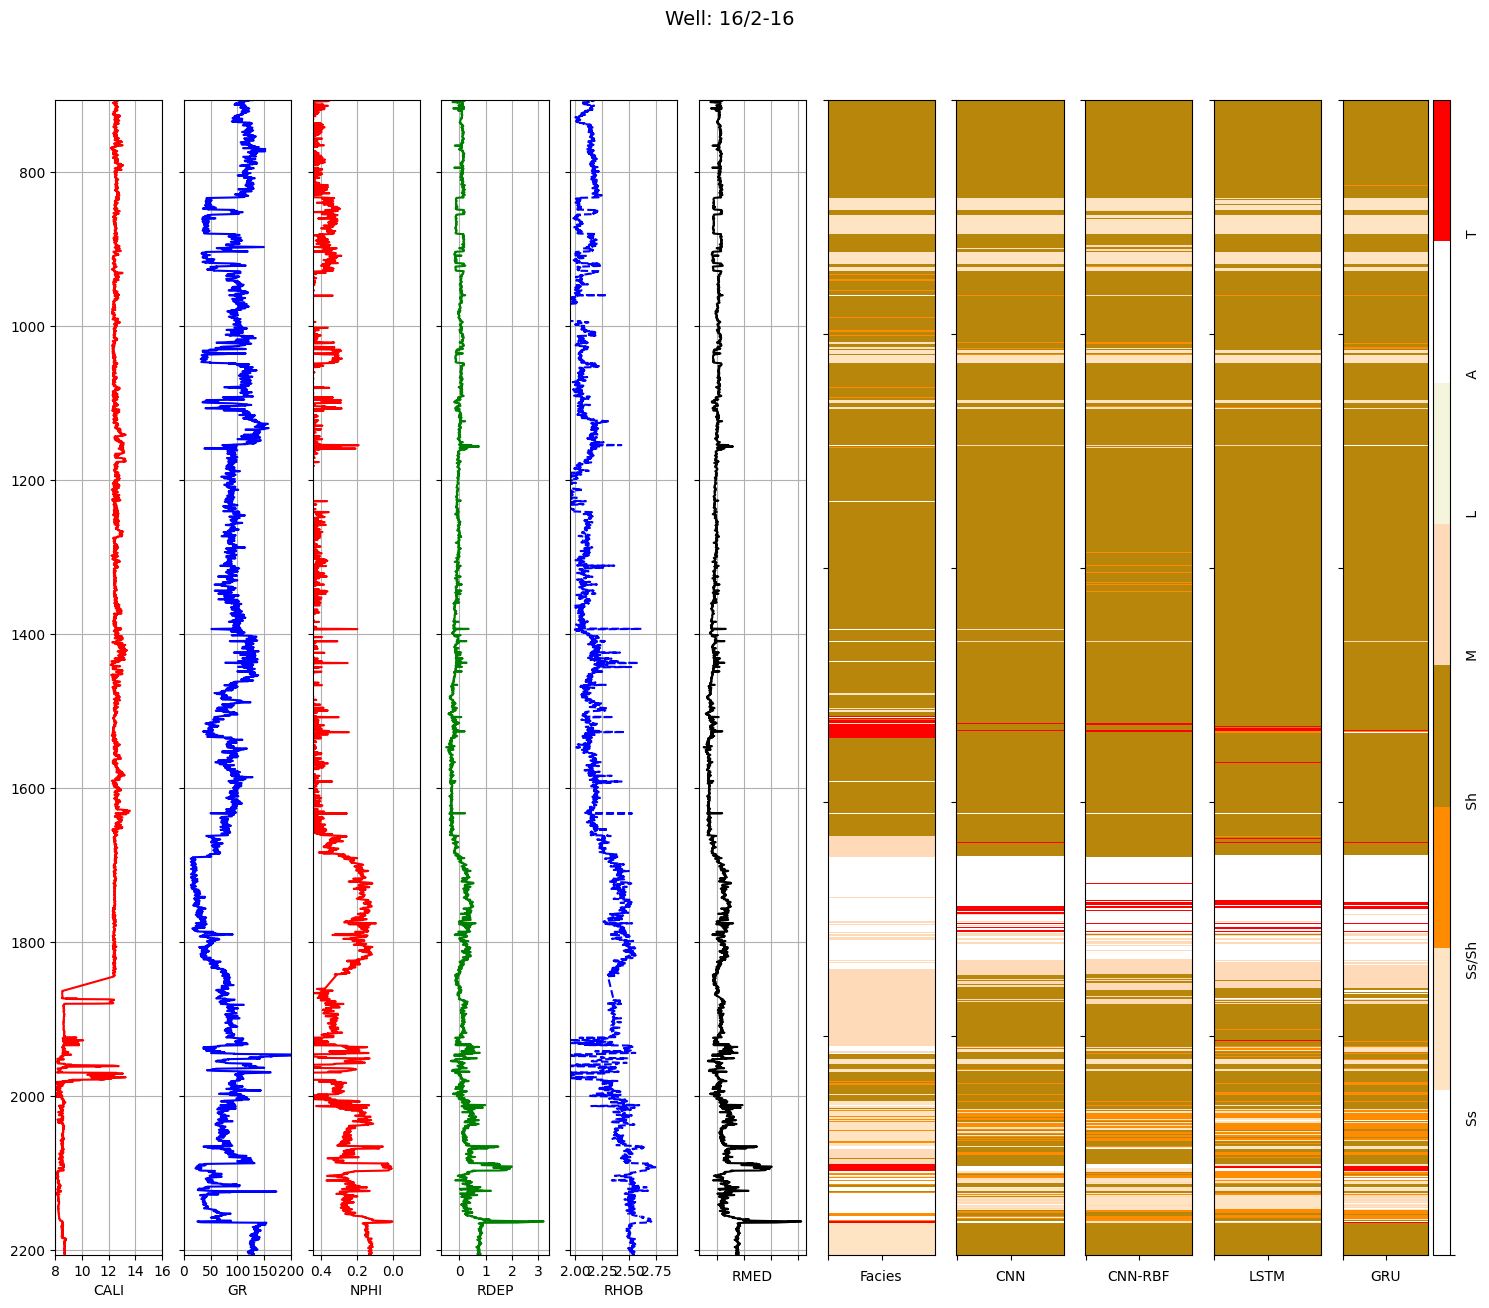

In [161]:
compare_facies_plot(blind, 'CNN','CNN-RBF', 'LSTM', 'GRU', facies_colors)